In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

In [2]:
import matplotlib.pyplot as plt

In [332]:
from functools import *
import json

In [404]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [406]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

In [4]:
dat = pd.read_csv("/Users/stevetran/Downloads/VinIDRecruitChallenge/VinIDRecruitChallenge_MLTrack_DataSet.csv")

In [5]:
dat["date"] = pd.to_datetime(dat["date"])

In [6]:
dat["day_of_week"] = dat["date"].map(lambda d: d.day_name())

In [7]:
dat.sort_values(by=["date"],inplace=True)

In [8]:
df_flatten = pd.read_csv("flatten.csv",date_parser=["date"])

In [9]:
df_flatten["date"] = pd.to_datetime(df_flatten["date"])

In [10]:
df_flatten.sort_values(by=["date"],ascending=True,inplace=True)

In [11]:
df_flatten["salesquantity"] = df_flatten["salesquantity"].map(np.ceil).astype('uint')

# Problem:
Predict which customers make at least 1 purchase in a given month using features generated from the 2 previous months

We can rephrase this problem into ML: The probability of repeatable buyers in next month.
We limit the problem that are looked back at least two months data

# Dataset

We have dataset from Feb to July, so we split the dataset
- Training: From (Feb, March, April), (March, April, May)
- Testing: (April,May,(June,July))

## Metric
We evaluate the model using F1 score, False Alarm score

In [12]:
train_dat = df_flatten[df_flatten["date"]<="2018-06-01"].copy(deep=True)
test_dat = df_flatten[df_flatten["date"]>"2018-06-01"].copy(deep=True)

In [13]:
len(train_dat["csn"].unique())

18032

In [14]:
len(test_dat["csn"].unique())

9002

In [407]:
def visualize_roc_kfold(classifier, X, y, cv):
    from sklearn.metrics import plot_roc_curve, auc, roc_auc_score
    from numpy import interp
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()

In [227]:
def calculate_prior_items(data):
    last_purchases_user_items = {}
    items_priors_day = np.zeros(len(data),dtype="uint")
    for user_id in data["csn"].unique():
        last_purchases_user_items[user_id] = {}
        
    idx = 0
    for _, row in data.sort_values(by=["date"],ascending=True).iterrows():
        user_id = row["csn"]
        item_id = row["article"]
        timestamp = row["date"]
        delta = 0
        if item_id in last_purchases_user_items[user_id]:        
            last_time_purchase = last_purchases_user_items[user_id][item_id]
            delta = (timestamp - last_time_purchase).days
        last_purchases_user_items[user_id][item_id] = timestamp
        items_priors_day[idx] = delta
        idx+=1
    return items_priors_day

In [228]:
def calculate_dow_features(data):
    features = {}
    for name, group in data.groupby(["csn"]):
        dow_cnt = np.zeros(7,dtype=np.uint)
        for idx in group["date"].map(lambda d: d.dayofweek).unique():
            dow_cnt[idx] += 1        
        
        features[name] = dow_cnt
    return pd.DataFrame(features).T

In [229]:
def calculate_reorder(data):
    features = {}
    for name, group in data.groupby(["csn"]):
        features[name] = {}
        sample = group.copy(deep=True)
        sample["prior_items"] = calculate_prior_items(sample)

        reorder_products = sample.query("prior_items>0")["article"].nunique()
        total_products = sample["article"].nunique()
        reorder_orders = sample.groupby(["date"])["prior_items"].sum()
        
        ratio = 1.0 * reorder_products / total_products
        new_products = total_products - reorder_products
        
        features[name]["reorder_rate"] = ratio
        features[name]["new_product"] = int(new_products)

        features[name]["orders_has_new_products"] = reorder_orders[reorder_orders==0].count()
        for item in sample[sample["prior_items"]>0]["salesquantity"].agg(["std","median","min","max"]).reset_index().values:
                k = "salesquantity_reorder_%s"%(item[0])
                features[name][k] = item[1]
        for item in sample[sample["prior_items"]>0]["prior_items"].agg(["std","median","min","max"]).reset_index().values:
                k = "prior_items_days_%s"%(item[0])
                features[name][k] = item[1]        
    feats_df = pd.DataFrame(features).T
    feats_df["new_product"] = feats_df["new_product"].astype('uint')
    return feats_df

In [230]:
def calculate_active(data):
    features = {}
    new_data = data.copy(deep=True)
    new_data["month"] = new_data["date"].map(lambda d: d.month)
    return new_data.groupby(["csn"])["month"].nunique()
        

In [231]:
agg_func = ['min','max','sum','std','mean','median']
def compute_last_n_days(data,time_max,lookbacks=[1,2,3,7,14,21,30]):    
    features = {}
    for user_id, group in data.groupby(["csn"]):
        features[user_id] = {}
        tmp = {}
        
#         s1 = time.time()
        group = group.set_index(["date"])
#         s2 = time.time()
        
        for lookback in lookbacks:
            timestamp = time_max - timedelta(days=lookback)
            stats = {
                    "unique_products":0,
                    "total_quantity": 0,
                    "sales": 0
            }
            if timestamp in group.index:
                df_filter = group.loc[timestamp:timestamp]
                stats = {
                    "unique_products":df_filter["article"].nunique(),
                    "total_quantity": df_filter["salesquantity"].sum(),
                    "sales": df_filter["price"].sum()
                }
            for k, v in stats.items():
                k_features = "last_{days}_days_{metric}".format(days=lookback,metric=k)
                tmp[k_features] = int(v)
        
#         s3 = time.time()
#         print("Delta: ",(s2-s1),(s3-s2))
        group = group.reset_index()
        
        last_purchase_date = group["date"].max()
        delta_days = (time_max - last_purchase_date).days
        tmp["user_last_purchase_date"] = int(delta_days)
        
        tmp["avg_products_in_cart"] = group.groupby(["date"])["article"].count().mean()
        tmp["number_of_products"] = group.groupby(["date"])["article"].count().sum()
        
        stats = group.groupby(["date"]).agg(
        {
            "salesquantity":agg_func,
            "price":agg_func
        }).mean().reset_index().values
        
        for i in range(len(stats)):
            k1, k2, val = stats[i]
            k = k1+"_"+k2
            tmp[k] = val       
            
        features[user_id] = tmp
            
    return pd.DataFrame(features).T

In [232]:
def get_features_from_df(df_train,df_test,df_last_time,time_max):
    df_last_purchase = compute_last_n_days(df_train,time_max=time_max)
    df_dow_features = calculate_dow_features(df_train)
    df_reorder_features = calculate_reorder(df_train)
    df_last_active = calculate_active(df_last_time)

    df_features = df_last_purchase.join(df_reorder_features)\
        .join(df_dow_features)\
        .join(df_last_active)\
        .copy(deep=True)\
        .reset_index()\
        .rename({"index":"csn"},axis=1)

    test_csn = set(df_test["csn"].unique())
    df_features["label"] = df_features["csn"].map(lambda d: 1 if d in test_csn else 0)
    print(df_features["label"].value_counts())
    return df_features

## Creating User Features

In [233]:
train_times = ["2018-02-01","2018-03-01","2018-04-01","2018-05-01","2018-06-01","2018-07-01"]

In [237]:
X_total = []
for i in range(len(train_times)-2):
    print("Processing ", train_times[i])
    start = train_times[i]
    end = train_times[i+1]
    upper = train_times[i+2]
    print(start,end,upper)
    
    d = set(df_flatten[(df_flatten["date"]>=start)&(df_flatten["date"]<end)]["csn"].unique())
    e = set(df_flatten[(df_flatten["date"]>=end)&(df_flatten["date"]<upper)]["csn"].unique())
    print(len(d),len(e),len(e.intersection(d)))
    train_df = df_flatten[(df_flatten["date"]>=start)&(df_flatten["date"]<end)]
    test_df = df_flatten[(df_flatten["date"]>=end)&(df_flatten["date"]<upper)]
    last_seen_df = df_flatten[df_flatten["date"]<end]
    
    X_total.append(get_features_from_df(train_df,test_df,last_seen_df,time_max=datetime.strptime(end,"%Y-%m-%d")))

Processing  2018-02-01
2018-02-01 2018-03-01 2018-04-01
9978 8940 5634
1    5634
0    4344
Name: label, dtype: int64
Processing  2018-03-01
2018-03-01 2018-04-01 2018-05-01
8940 9078 5497
1    5497
0    3443
Name: label, dtype: int64
Processing  2018-04-01
2018-04-01 2018-05-01 2018-06-01
9078 9106 5471
1    5471
0    3607
Name: label, dtype: int64
Processing  2018-05-01
2018-05-01 2018-06-01 2018-07-01
9106 9210 5441
1    5441
0    3665
Name: label, dtype: int64


In [238]:
df_features = pd.concat(X_total)

In [256]:
df_for_train = pd.concat(X_total[:3])
df_for_test = X_total[-1].copy(deep=True)

In [240]:
# df_features.to_csv("df_features.csv",index=None)

In [265]:
df_for_train.fillna(-1,inplace=True)
df_for_test.fillna(-1,inplace=True)

In [268]:
X = df_for_train.drop(["csn","label"],axis=1).values
y = df_for_train["label"].values

In [329]:
X_test = df_for_test.drop(["csn","label"],axis=1).values
y_test = df_for_test["label"].values

## Logistic Regression

In [408]:
# Normalize Features to [0,1] scale
scaler = MinMaxScaler().fit(X)

In [409]:
X_transform = scaler.transform(X)

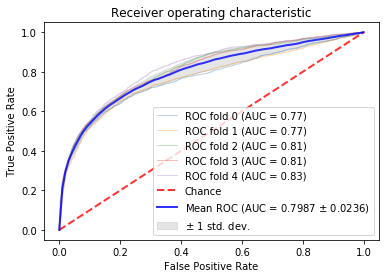

In [324]:
visualize_roc_kfold(LogisticRegression(max_iter=10000),X_transform,y,cv=KFold(n_splits=5))

## Features interaction

In [410]:
poly = PolynomialFeatures(degree=2)

In [411]:
X_transform_degree = poly.fit_transform(X)

In [ ]:
visualize_roc_kfold(LogisticRegression(max_iter=10000),X_transform_degree,y,cv=KFold(n_splits=5))

## LightGBM

In [325]:
import lightgbm

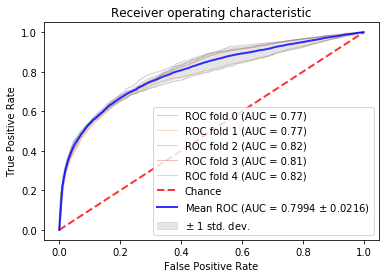

In [328]:
visualize_roc_kfold(lightgbm.LGBMClassifier(
                n_estimators=400,
                subsample=0.9,                                                          
                learning_rate=0.01),X,y,cv=KFold(n_splits=5))

In [343]:
model = lightgbm.LGBMClassifier(
                n_estimators=400,
                subsample=0.85,                                                          
                learning_rate=0.01).fit(X,y)

In [344]:
y_pred = model.predict_proba(X_test)
print(roc_auc_score(y_true=y_test,y_score=y_pred[:,1]))

0.8212818243978002


In [362]:
df_important = pd.DataFrame(list(zip(df_features.drop(["csn","label"],axis=1).columns,model.feature_importances_)),columns=["feature","coff"])\
    .set_index(["feature"])\
    .sort_values(by="coff",ascending=False)

In [363]:
df_important["coff_norm"] = df_important["coff"]/df_important["coff"].max()

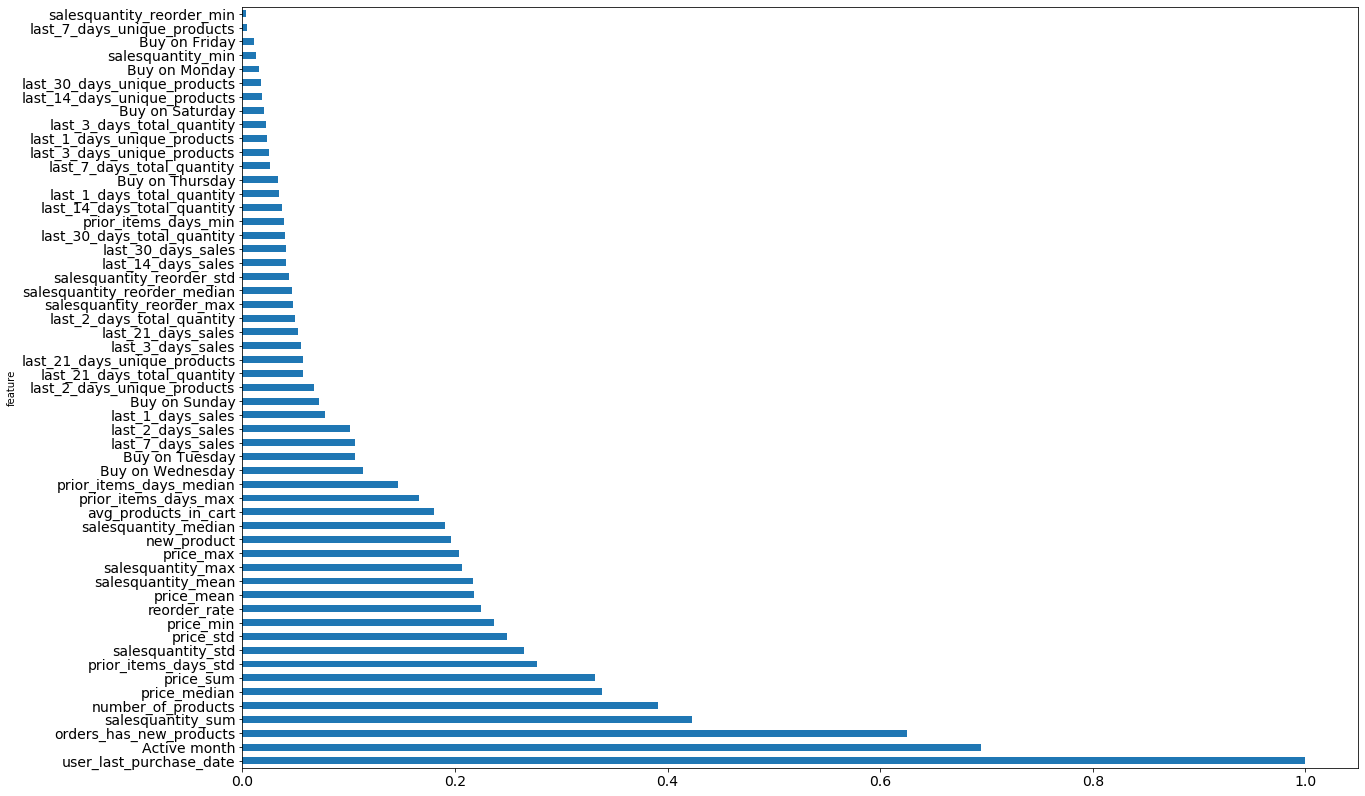

In [379]:
df_important["coff_norm"]\
    .rename({0: "Buy on Monday",
             1: "Buy on Tuesday",
             2: "Buy on Wednesday",
             3: "Buy on Thursday",
             4: "Buy on Friday",
             5: "Buy on Saturday",
             6: "Buy on Sunday",
             "month": "Active month"
            }).sort_values(ascending=False).plot(kind="barh",figsize=(20,14),fontsize=14)

In [380]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train,y_val = train_test_split(X,y,test_size=0.2,stratify=y,random_state=4111)

In [384]:
import lightgbm as lgb
train_data= lgb.Dataset(X_train,label=y_train,free_raw_data=False)
valid_data = lgb.Dataset(X_val,label=y_val,free_raw_data=False)

In [401]:
params = {
        'num_leaves': 31, 
        'objective': 'binary',
        'metric':['auc', 'binary_logloss'],
        'num_round': 1400,
        'bagging_fraction':0.9,
        'bagging_freq':1,
        'learning_rate':0.001,
        'lambda_l1':1.0,
        'lambda_l2':1.0,
        'max_depth': -1,
        'predict_raw_score':True
}
evals_result = {}
bst = lgb.train(params, train_data, params['num_round'], valid_sets=[train_data,valid_data],evals_result=evals_result)

/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's auc: 0.801165	training's binary_logloss: 0.675474	valid_1's auc: 0.804474	valid_1's binary_logloss: 0.675459
[2]	training's auc: 0.802894	training's binary_logloss: 0.675203	valid_1's auc: 0.806221	valid_1's binary_logloss: 0.675185
[3]	training's auc: 0.80429	training's binary_logloss: 0.674933	valid_1's auc: 0.805975	valid_1's binary_logloss: 0.674912
[4]	training's auc: 0.805052	training's binary_logloss: 0.674664	valid_1's auc: 0.805794	valid_1's binary_logloss: 0.674639
[5]	training's auc: 0.806117	training's binary_logloss: 0.674396	valid_1's auc: 0.806272	valid_1's binary_logloss: 0.674367
[6]	training's auc: 0.806008	training's binary_logloss: 0.674127	valid_1's auc: 0.805986	valid_1's binary_logloss: 0.674096
[7]	training's auc: 0.80627	training's binary_logloss: 0.673861	valid_1's auc: 0.806038	valid_1's binary_logloss: 0.673826
[8]	training's auc: 0.806313	training's binary_logloss: 0.673594	valid_1's auc: 0.806422	valid_1's binary_logloss: 0.673556
[9]	traini

[83]	training's auc: 0.807934	training's binary_logloss: 0.654921	valid_1's auc: 0.806929	valid_1's binary_logloss: 0.65469
[84]	training's auc: 0.807926	training's binary_logloss: 0.654691	valid_1's auc: 0.806913	valid_1's binary_logloss: 0.654457
[85]	training's auc: 0.807918	training's binary_logloss: 0.654461	valid_1's auc: 0.80697	valid_1's binary_logloss: 0.654224
[86]	training's auc: 0.807926	training's binary_logloss: 0.654231	valid_1's auc: 0.806913	valid_1's binary_logloss: 0.653993
[87]	training's auc: 0.807948	training's binary_logloss: 0.654001	valid_1's auc: 0.806918	valid_1's binary_logloss: 0.653761
[88]	training's auc: 0.807963	training's binary_logloss: 0.653771	valid_1's auc: 0.806924	valid_1's binary_logloss: 0.653527
[89]	training's auc: 0.807952	training's binary_logloss: 0.653542	valid_1's auc: 0.806919	valid_1's binary_logloss: 0.653295
[90]	training's auc: 0.807947	training's binary_logloss: 0.653313	valid_1's auc: 0.806934	valid_1's binary_logloss: 0.653064
[9

[157]	training's auc: 0.808326	training's binary_logloss: 0.63888	valid_1's auc: 0.807096	valid_1's binary_logloss: 0.638504
[158]	training's auc: 0.808323	training's binary_logloss: 0.638678	valid_1's auc: 0.807088	valid_1's binary_logloss: 0.638299
[159]	training's auc: 0.808335	training's binary_logloss: 0.638476	valid_1's auc: 0.807076	valid_1's binary_logloss: 0.638094
[160]	training's auc: 0.808347	training's binary_logloss: 0.638275	valid_1's auc: 0.807108	valid_1's binary_logloss: 0.637891
[161]	training's auc: 0.808363	training's binary_logloss: 0.638073	valid_1's auc: 0.807088	valid_1's binary_logloss: 0.637689
[162]	training's auc: 0.808363	training's binary_logloss: 0.637872	valid_1's auc: 0.807075	valid_1's binary_logloss: 0.637488
[163]	training's auc: 0.808369	training's binary_logloss: 0.63767	valid_1's auc: 0.807076	valid_1's binary_logloss: 0.637285
[164]	training's auc: 0.808365	training's binary_logloss: 0.63747	valid_1's auc: 0.807065	valid_1's binary_logloss: 0.63

[233]	training's auc: 0.808778	training's binary_logloss: 0.624481	valid_1's auc: 0.807251	valid_1's binary_logloss: 0.623995
[234]	training's auc: 0.808788	training's binary_logloss: 0.624304	valid_1's auc: 0.807246	valid_1's binary_logloss: 0.623819
[235]	training's auc: 0.808796	training's binary_logloss: 0.624127	valid_1's auc: 0.807254	valid_1's binary_logloss: 0.623642
[236]	training's auc: 0.808794	training's binary_logloss: 0.62395	valid_1's auc: 0.807255	valid_1's binary_logloss: 0.623461
[237]	training's auc: 0.808813	training's binary_logloss: 0.623774	valid_1's auc: 0.807283	valid_1's binary_logloss: 0.623285
[238]	training's auc: 0.808818	training's binary_logloss: 0.623599	valid_1's auc: 0.807309	valid_1's binary_logloss: 0.623108
[239]	training's auc: 0.808829	training's binary_logloss: 0.623424	valid_1's auc: 0.807326	valid_1's binary_logloss: 0.622932
[240]	training's auc: 0.808833	training's binary_logloss: 0.623248	valid_1's auc: 0.807314	valid_1's binary_logloss: 0.

[334]	training's auc: 0.809533	training's binary_logloss: 0.608083	valid_1's auc: 0.807647	valid_1's binary_logloss: 0.607499
[335]	training's auc: 0.809526	training's binary_logloss: 0.607934	valid_1's auc: 0.807658	valid_1's binary_logloss: 0.607351
[336]	training's auc: 0.809537	training's binary_logloss: 0.607787	valid_1's auc: 0.807661	valid_1's binary_logloss: 0.607204
[337]	training's auc: 0.809548	training's binary_logloss: 0.607639	valid_1's auc: 0.807684	valid_1's binary_logloss: 0.607053
[338]	training's auc: 0.809547	training's binary_logloss: 0.60749	valid_1's auc: 0.80768	valid_1's binary_logloss: 0.606905
[339]	training's auc: 0.809558	training's binary_logloss: 0.607341	valid_1's auc: 0.807673	valid_1's binary_logloss: 0.606756
[340]	training's auc: 0.809566	training's binary_logloss: 0.607193	valid_1's auc: 0.807696	valid_1's binary_logloss: 0.606607
[341]	training's auc: 0.809572	training's binary_logloss: 0.607046	valid_1's auc: 0.807701	valid_1's binary_logloss: 0.6

[429]	training's auc: 0.810123	training's binary_logloss: 0.595005	valid_1's auc: 0.80831	valid_1's binary_logloss: 0.594372
[430]	training's auc: 0.810125	training's binary_logloss: 0.594878	valid_1's auc: 0.808301	valid_1's binary_logloss: 0.594246
[431]	training's auc: 0.810132	training's binary_logloss: 0.594751	valid_1's auc: 0.808297	valid_1's binary_logloss: 0.59412
[432]	training's auc: 0.81014	training's binary_logloss: 0.594624	valid_1's auc: 0.808304	valid_1's binary_logloss: 0.593991
[433]	training's auc: 0.810145	training's binary_logloss: 0.594498	valid_1's auc: 0.808307	valid_1's binary_logloss: 0.593864
[434]	training's auc: 0.810147	training's binary_logloss: 0.594372	valid_1's auc: 0.808321	valid_1's binary_logloss: 0.593738
[435]	training's auc: 0.81015	training's binary_logloss: 0.594245	valid_1's auc: 0.808299	valid_1's binary_logloss: 0.593614
[436]	training's auc: 0.810155	training's binary_logloss: 0.59412	valid_1's auc: 0.808304	valid_1's binary_logloss: 0.5934

[495]	training's auc: 0.810603	training's binary_logloss: 0.587058	valid_1's auc: 0.808713	valid_1's binary_logloss: 0.586417
[496]	training's auc: 0.81059	training's binary_logloss: 0.586945	valid_1's auc: 0.808712	valid_1's binary_logloss: 0.586302
[497]	training's auc: 0.810606	training's binary_logloss: 0.586831	valid_1's auc: 0.80873	valid_1's binary_logloss: 0.586188
[498]	training's auc: 0.8106	training's binary_logloss: 0.586718	valid_1's auc: 0.808734	valid_1's binary_logloss: 0.586075
[499]	training's auc: 0.810618	training's binary_logloss: 0.586605	valid_1's auc: 0.808738	valid_1's binary_logloss: 0.585964
[500]	training's auc: 0.810619	training's binary_logloss: 0.586492	valid_1's auc: 0.808735	valid_1's binary_logloss: 0.585849
[501]	training's auc: 0.810633	training's binary_logloss: 0.586378	valid_1's auc: 0.80877	valid_1's binary_logloss: 0.585732
[502]	training's auc: 0.810641	training's binary_logloss: 0.586264	valid_1's auc: 0.808764	valid_1's binary_logloss: 0.5856

[599]	training's auc: 0.811136	training's binary_logloss: 0.576137	valid_1's auc: 0.80902	valid_1's binary_logloss: 0.575548
[600]	training's auc: 0.811141	training's binary_logloss: 0.57604	valid_1's auc: 0.809027	valid_1's binary_logloss: 0.575452
[601]	training's auc: 0.811147	training's binary_logloss: 0.575943	valid_1's auc: 0.809033	valid_1's binary_logloss: 0.575356
[602]	training's auc: 0.811155	training's binary_logloss: 0.575847	valid_1's auc: 0.809047	valid_1's binary_logloss: 0.57526
[603]	training's auc: 0.811176	training's binary_logloss: 0.57575	valid_1's auc: 0.809042	valid_1's binary_logloss: 0.575166
[604]	training's auc: 0.811182	training's binary_logloss: 0.575654	valid_1's auc: 0.809048	valid_1's binary_logloss: 0.575072
[605]	training's auc: 0.811187	training's binary_logloss: 0.575559	valid_1's auc: 0.809038	valid_1's binary_logloss: 0.574978
[606]	training's auc: 0.81119	training's binary_logloss: 0.575463	valid_1's auc: 0.809041	valid_1's binary_logloss: 0.5748

[684]	training's auc: 0.811669	training's binary_logloss: 0.568451	valid_1's auc: 0.809314	valid_1's binary_logloss: 0.567955
[685]	training's auc: 0.811673	training's binary_logloss: 0.568366	valid_1's auc: 0.809319	valid_1's binary_logloss: 0.567872
[686]	training's auc: 0.811679	training's binary_logloss: 0.568282	valid_1's auc: 0.809322	valid_1's binary_logloss: 0.567789
[687]	training's auc: 0.811695	training's binary_logloss: 0.568198	valid_1's auc: 0.809333	valid_1's binary_logloss: 0.567707
[688]	training's auc: 0.811703	training's binary_logloss: 0.568113	valid_1's auc: 0.80933	valid_1's binary_logloss: 0.567624
[689]	training's auc: 0.81171	training's binary_logloss: 0.568029	valid_1's auc: 0.809326	valid_1's binary_logloss: 0.567542
[690]	training's auc: 0.811708	training's binary_logloss: 0.567945	valid_1's auc: 0.809327	valid_1's binary_logloss: 0.567457
[691]	training's auc: 0.811714	training's binary_logloss: 0.56786	valid_1's auc: 0.809327	valid_1's binary_logloss: 0.56

[777]	training's auc: 0.81221	training's binary_logloss: 0.5611	valid_1's auc: 0.809669	valid_1's binary_logloss: 0.560759
[778]	training's auc: 0.812212	training's binary_logloss: 0.561028	valid_1's auc: 0.809678	valid_1's binary_logloss: 0.560688
[779]	training's auc: 0.812222	training's binary_logloss: 0.560953	valid_1's auc: 0.809673	valid_1's binary_logloss: 0.560613
[780]	training's auc: 0.812228	training's binary_logloss: 0.56088	valid_1's auc: 0.809667	valid_1's binary_logloss: 0.560543
[781]	training's auc: 0.81223	training's binary_logloss: 0.560807	valid_1's auc: 0.80967	valid_1's binary_logloss: 0.560472
[782]	training's auc: 0.812227	training's binary_logloss: 0.560733	valid_1's auc: 0.809675	valid_1's binary_logloss: 0.560398
[783]	training's auc: 0.812231	training's binary_logloss: 0.56066	valid_1's auc: 0.809677	valid_1's binary_logloss: 0.560326
[784]	training's auc: 0.812235	training's binary_logloss: 0.560588	valid_1's auc: 0.809679	valid_1's binary_logloss: 0.560254

[873]	training's auc: 0.812694	training's binary_logloss: 0.554505	valid_1's auc: 0.809794	valid_1's binary_logloss: 0.55439
[874]	training's auc: 0.812699	training's binary_logloss: 0.554442	valid_1's auc: 0.809796	valid_1's binary_logloss: 0.554328
[875]	training's auc: 0.81271	training's binary_logloss: 0.554377	valid_1's auc: 0.809791	valid_1's binary_logloss: 0.554268
[876]	training's auc: 0.812714	training's binary_logloss: 0.554314	valid_1's auc: 0.809787	valid_1's binary_logloss: 0.554207
[877]	training's auc: 0.812716	training's binary_logloss: 0.554252	valid_1's auc: 0.809789	valid_1's binary_logloss: 0.554144
[878]	training's auc: 0.812723	training's binary_logloss: 0.554188	valid_1's auc: 0.809792	valid_1's binary_logloss: 0.554085
[879]	training's auc: 0.81273	training's binary_logloss: 0.554125	valid_1's auc: 0.809794	valid_1's binary_logloss: 0.554026
[880]	training's auc: 0.812733	training's binary_logloss: 0.554063	valid_1's auc: 0.809797	valid_1's binary_logloss: 0.55

[939]	training's auc: 0.813068	training's binary_logloss: 0.550478	valid_1's auc: 0.809869	valid_1's binary_logloss: 0.55055
[940]	training's auc: 0.813069	training's binary_logloss: 0.550419	valid_1's auc: 0.809871	valid_1's binary_logloss: 0.550495
[941]	training's auc: 0.81307	training's binary_logloss: 0.550361	valid_1's auc: 0.809874	valid_1's binary_logloss: 0.550438
[942]	training's auc: 0.813075	training's binary_logloss: 0.550303	valid_1's auc: 0.809874	valid_1's binary_logloss: 0.550384
[943]	training's auc: 0.813076	training's binary_logloss: 0.550245	valid_1's auc: 0.809879	valid_1's binary_logloss: 0.550328
[944]	training's auc: 0.813079	training's binary_logloss: 0.550187	valid_1's auc: 0.809883	valid_1's binary_logloss: 0.550272
[945]	training's auc: 0.813083	training's binary_logloss: 0.55013	valid_1's auc: 0.809888	valid_1's binary_logloss: 0.550218
[946]	training's auc: 0.81309	training's binary_logloss: 0.550073	valid_1's auc: 0.809888	valid_1's binary_logloss: 0.550

[1018]	training's auc: 0.813531	training's binary_logloss: 0.546129	valid_1's auc: 0.810039	valid_1's binary_logloss: 0.546435
[1019]	training's auc: 0.813532	training's binary_logloss: 0.546078	valid_1's auc: 0.810043	valid_1's binary_logloss: 0.546386
[1020]	training's auc: 0.813538	training's binary_logloss: 0.546026	valid_1's auc: 0.810043	valid_1's binary_logloss: 0.546337
[1021]	training's auc: 0.813544	training's binary_logloss: 0.545974	valid_1's auc: 0.810046	valid_1's binary_logloss: 0.54629
[1022]	training's auc: 0.813552	training's binary_logloss: 0.545921	valid_1's auc: 0.810045	valid_1's binary_logloss: 0.546242
[1023]	training's auc: 0.813555	training's binary_logloss: 0.545869	valid_1's auc: 0.810041	valid_1's binary_logloss: 0.546195
[1024]	training's auc: 0.81356	training's binary_logloss: 0.545817	valid_1's auc: 0.810044	valid_1's binary_logloss: 0.546145
[1025]	training's auc: 0.813565	training's binary_logloss: 0.545766	valid_1's auc: 0.81004	valid_1's binary_loglo

[1089]	training's auc: 0.813897	training's binary_logloss: 0.542613	valid_1's auc: 0.810068	valid_1's binary_logloss: 0.543174
[1090]	training's auc: 0.813901	training's binary_logloss: 0.542565	valid_1's auc: 0.810072	valid_1's binary_logloss: 0.543131
[1091]	training's auc: 0.813905	training's binary_logloss: 0.542518	valid_1's auc: 0.810071	valid_1's binary_logloss: 0.543088
[1092]	training's auc: 0.813909	training's binary_logloss: 0.542471	valid_1's auc: 0.810072	valid_1's binary_logloss: 0.543044
[1093]	training's auc: 0.81392	training's binary_logloss: 0.542424	valid_1's auc: 0.810067	valid_1's binary_logloss: 0.543004
[1094]	training's auc: 0.813926	training's binary_logloss: 0.542377	valid_1's auc: 0.810072	valid_1's binary_logloss: 0.542961
[1095]	training's auc: 0.813933	training's binary_logloss: 0.54233	valid_1's auc: 0.810074	valid_1's binary_logloss: 0.542917
[1096]	training's auc: 0.81394	training's binary_logloss: 0.542284	valid_1's auc: 0.810078	valid_1's binary_loglo

[1162]	training's auc: 0.814307	training's binary_logloss: 0.539324	valid_1's auc: 0.810142	valid_1's binary_logloss: 0.540156
[1163]	training's auc: 0.814314	training's binary_logloss: 0.539281	valid_1's auc: 0.810144	valid_1's binary_logloss: 0.540118
[1164]	training's auc: 0.814317	training's binary_logloss: 0.539239	valid_1's auc: 0.81015	valid_1's binary_logloss: 0.540078
[1165]	training's auc: 0.814319	training's binary_logloss: 0.539197	valid_1's auc: 0.81015	valid_1's binary_logloss: 0.540039
[1166]	training's auc: 0.814324	training's binary_logloss: 0.539154	valid_1's auc: 0.810156	valid_1's binary_logloss: 0.54
[1167]	training's auc: 0.814331	training's binary_logloss: 0.539112	valid_1's auc: 0.810159	valid_1's binary_logloss: 0.539962
[1168]	training's auc: 0.814334	training's binary_logloss: 0.539069	valid_1's auc: 0.81016	valid_1's binary_logloss: 0.539924
[1169]	training's auc: 0.814335	training's binary_logloss: 0.539027	valid_1's auc: 0.810164	valid_1's binary_logloss: 

[1248]	training's auc: 0.814692	training's binary_logloss: 0.535853	valid_1's auc: 0.810231	valid_1's binary_logloss: 0.537013
[1249]	training's auc: 0.814695	training's binary_logloss: 0.535815	valid_1's auc: 0.810233	valid_1's binary_logloss: 0.536979
[1250]	training's auc: 0.814703	training's binary_logloss: 0.535776	valid_1's auc: 0.810233	valid_1's binary_logloss: 0.536944
[1251]	training's auc: 0.814707	training's binary_logloss: 0.535738	valid_1's auc: 0.810233	valid_1's binary_logloss: 0.536909
[1252]	training's auc: 0.814715	training's binary_logloss: 0.5357	valid_1's auc: 0.810242	valid_1's binary_logloss: 0.536874
[1253]	training's auc: 0.814718	training's binary_logloss: 0.535661	valid_1's auc: 0.810243	valid_1's binary_logloss: 0.53684
[1254]	training's auc: 0.814723	training's binary_logloss: 0.535623	valid_1's auc: 0.810254	valid_1's binary_logloss: 0.536805
[1255]	training's auc: 0.814727	training's binary_logloss: 0.535586	valid_1's auc: 0.810254	valid_1's binary_loglo

[1324]	training's auc: 0.81507	training's binary_logloss: 0.533084	valid_1's auc: 0.810325	valid_1's binary_logloss: 0.534565
[1325]	training's auc: 0.815081	training's binary_logloss: 0.533048	valid_1's auc: 0.810325	valid_1's binary_logloss: 0.534536
[1326]	training's auc: 0.815084	training's binary_logloss: 0.533014	valid_1's auc: 0.810324	valid_1's binary_logloss: 0.534505
[1327]	training's auc: 0.815089	training's binary_logloss: 0.532979	valid_1's auc: 0.810327	valid_1's binary_logloss: 0.534474
[1328]	training's auc: 0.815093	training's binary_logloss: 0.532945	valid_1's auc: 0.810327	valid_1's binary_logloss: 0.534442
[1329]	training's auc: 0.815098	training's binary_logloss: 0.53291	valid_1's auc: 0.810323	valid_1's binary_logloss: 0.534411
[1330]	training's auc: 0.815106	training's binary_logloss: 0.532875	valid_1's auc: 0.810326	valid_1's binary_logloss: 0.53438
[1331]	training's auc: 0.81511	training's binary_logloss: 0.532841	valid_1's auc: 0.810321	valid_1's binary_loglos

[1399]	training's auc: 0.815438	training's binary_logloss: 0.530594	valid_1's auc: 0.81036	valid_1's binary_logloss: 0.532398
[1400]	training's auc: 0.815446	training's binary_logloss: 0.530562	valid_1's auc: 0.81036	valid_1's binary_logloss: 0.532371


In [402]:
y_pred = bst.predict(X_test)
print(roc_auc_score(y_true=y_test,y_score=y_pred))

0.8201344799339461
